In [0]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import matplotlib.animation as animation
from IPython.display import HTML

import copy

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
imsize = 256 if torch.cuda.is_available() else 128 

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()]) 


def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("./art.png")
content_img = image_loader("./rushmore.jpg")

print(style_img.size(), content_img.size())

assert style_img.size() == content_img.size(), "we need to import style and content images of the same size"

torch.Size([1, 3, 256, 358]) torch.Size([1, 3, 256, 358])


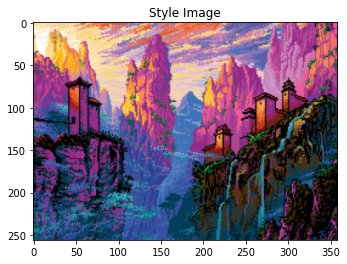

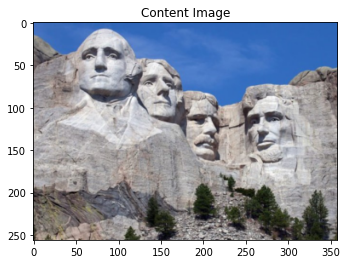

In [7]:
unloader = transforms.ToPILImage() 

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [0]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [0]:
def gram_matrix(input):
    a, b, c, d = input.size()  
    # a=batch size (= 1 here)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    # Resize to form features matrix
    features = input.view(a * b, c * d)

    # Compute gram matrix
    G = torch.mm(features, features.t())

    # Normalize the gram matrix
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [10]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)


class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [0]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [0]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [0]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=750,
                       style_weight=2000000, content_weight=5):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing...')
    images_during_training = []
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)
            
            # Store images at regular intervals for being included in the animation
            if run[0] % 50 == 0:
                images_during_training.append(input_img.clone())

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)
    images_during_training.append(input_img)

    return input_img, images_during_training

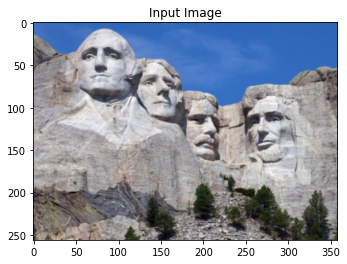

Building the style transfer model..
Optimizing...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [50]:
Style Loss : 1329.423218 Content Loss: 290.964874

run [100]:
Style Loss : 470.312561 Content Loss: 280.357330

run [150]:
Style Loss : 230.802383 Content Loss: 262.174408

run [200]:
Style Loss : 131.467865 Content Loss: 242.301193

run [250]:
Style Loss : 91.130089 Content Loss: 221.519394

run [300]:
Style Loss : 73.823456 Content Loss: 201.458862

run [350]:
Style Loss : 56.116535 Content Loss: 187.412247

run [400]:
Style Loss : 46.539272 Content Loss: 174.881470

run [450]:
Style Loss : 37.940979 Content Loss: 164.454071

run [500]:
Style Loss : 32.058372 Content Loss: 157.436447

run [550]:
Style Loss : 30.172235 Content Loss: 150.714355

run [600]:
Style Loss : 40.789795 Content Loss: 152.195312

run [650]:
Style Loss : 83.796890 Content Loss: 140.729004

run [700]:
Style Loss : 24.155947 Content Loss: 137.394577

run [750]:
Style Loss : 21.490459 Content Loss: 134.743164



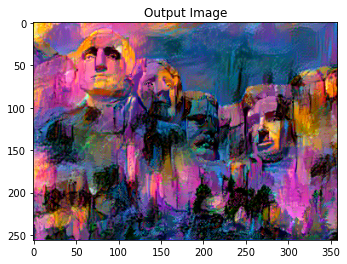

In [45]:
input_img = content_img.clone()

plt.figure()
imshow(input_img, title='Input Image')

output, images_during_training = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img, input_img, 50, 2000000, 5)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

Fetching images...
Preparing animation...


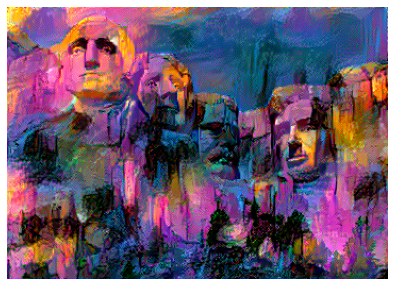

In [47]:
fig = plt.figure(figsize=(7, 5))
plt.axis("off")
ims = []

print("Fetching images...")
for image in images_during_training[1:]:
    image = image.cpu().clone() 
    image = image.squeeze(0)
    image = unloader(image)
    ims.append([plt.imshow(image, animated = True)])

print("Preparing animation...\n")
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())